## Automated Detection of Layers from Pictures

This cell loads one image at a time.

Non-Stacked


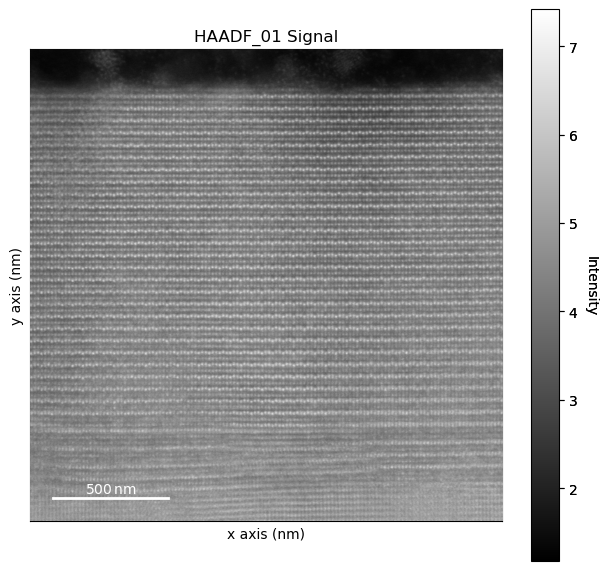

In [1]:
import skimage
import matplotlib.pyplot as plt
import hyperspy.api as hs
import sys
sys.path.append('..')
import util.crop

stack_num = 0 # The index of stacked image

# Change the name of s_load to load different plots.
# Note that some datasets are in stacks and their data will be 3-dimension,
# where the first dimention is the index of a single stacked image. We want to
# look at one image each of the time, so for those stacked images, please change
# stack_num to view different images.

# Load one file at a time.
# These commented files are some that I want think could be reevaluated later for references.
s_load = hs.load('../data/images/Jaume LFO/HAADF_01.dm3')

if len(s_load.data.shape) == 2: # Non-stacked
    print("Non-Stacked")
    s = s_load
else: # Stacked, where s_load.data.shape = 3
    print("Stacked")
    s = s_load.inav[stack_num]

# Plot the image in pixels. We can plot in nanometers by simply doing s.plot().
import copy
s_copy = copy.deepcopy(s)
for ax in s_copy.axes_manager.signal_axes:
    ax.scale = 1.0
    ax.offset = 0.0

plt.close()
s_copy.plot()

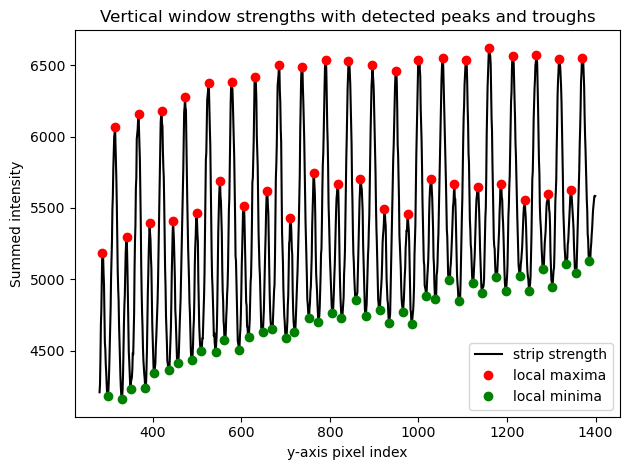

In [2]:
import scipy.signal
import numpy as np

left_bound = 500 # TUNE THIS
right_bound = 1700 # TUNE THIS
start_pixel = 280 # TUNE THIS
end_pixel = 1400 # TUNE THIS
# window_height_nm = None

crop = util.crop.Crop(s, left_bound, right_bound, start_pixel, end_pixel)
crop.get_vertical_peaks(detect_height = 1, get_plot=True)

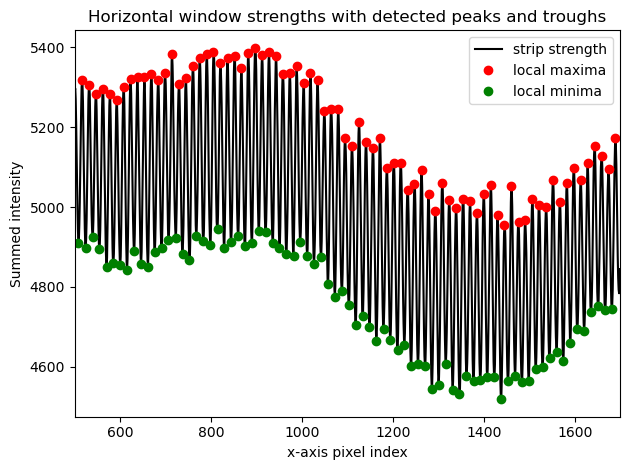

In [3]:
crop.get_horizontal_peaks(detect_width = 1, get_plot=True)

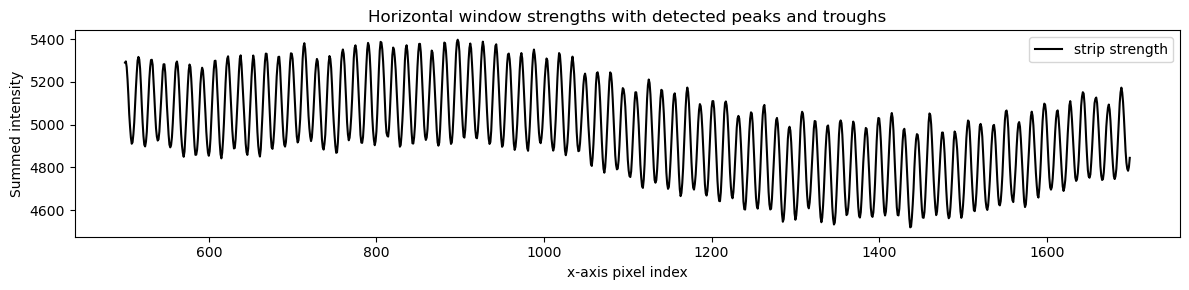

In [4]:
plt.figure(figsize=(12,3))
x_coords   = np.arange(crop.left, crop.right)
plt.plot(x_coords, crop.x_axis_scan_strengths, '-k', label='strip strength')
# plt.plot(crop.vertical_peaks,   crop.x_axis_scan_strengths[crop.vertical_peaks - crop.left],   'ro', label='local maxima')
# plt.plot(crop.vertical_troughs, crop.x_axis_scan_strengths[crop.vertical_troughs - crop.left], 'go', label='local minima')
plt.xlabel('x-axis pixel index');  plt.ylabel('Summed intensity')
plt.title('Horizontal window strengths with detected peaks and troughs')
plt.legend()
# plt.xlim(y_coords[0], y_coords[-1])  # matches data coordinates
plt.tight_layout(); plt.show()

## Distance Analysis

In [11]:
crop.build_grid_dict()

crop.get_atom_positions()
# crop.refine_atom_positions()
positions_array = np.array(list(crop.atom_positions.values()))

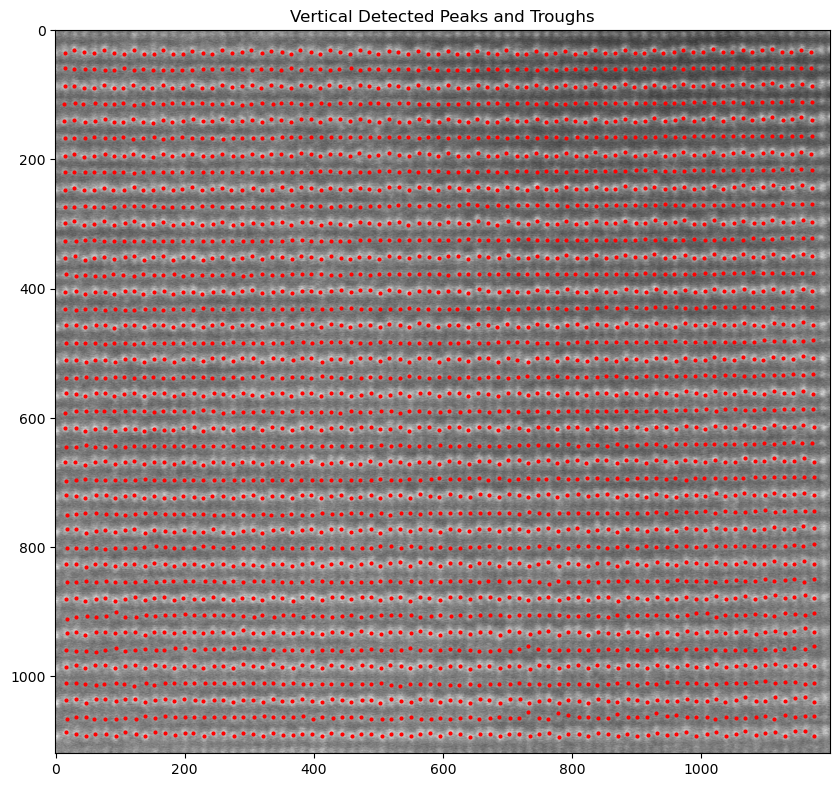

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(crop.roi, cmap='gray', alpha = 0.8)

# for x in crop.vertical_peaks:
#     ax.axvline(x-crop.left, color='red', linestyle='--', linewidth=1)
# for x in crop.vertical_troughs:
#     ax.axvline(x-crop.left, color='green', linestyle='--', linewidth=1)

# for y in crop.horizontal_peaks:
#     ax.axhline(y-crop.start, color='red', linestyle='--', linewidth=1)
# for y in crop.horizontal_troughs:
#     ax.axhline(y-crop.start, color='green', linestyle='--', linewidth=1)

ax.scatter(positions_array[:,0], positions_array[:,1], s=4, c='r')

plt.title("Vertical Detected Peaks and Troughs")
plt.show()


In [47]:
import numpy as np

diffs = {}  # store results keyed by (i, j)

for patch in crop.grid.values():
    pi, pj = patch.index

    # Skip if neighbors would be out of bounds:
    if ((pi-3, pj) not in crop.grid or (pi+3, pj) not in crop.grid 
        or (pi, pj-2) not in crop.grid or (pi, pj+2) not in crop.grid):
        continue

    # Collect positions of 4-neighbors: up, down, left, right
    neighbors = [
        np.array(crop.grid[pi-3, pj].atom_position),
        np.array(crop.grid[pi+3, pj].atom_position),
        np.array(crop.grid[pi-3, pj-2].atom_position),
        np.array(crop.grid[pi+3, pj-2].atom_position),
        np.array(crop.grid[pi-3, pj+2].atom_position),
        np.array(crop.grid[pi+3, pj+2].atom_position)
    ]
    mean_neighbor = np.mean(neighbors, axis=0)
    diffs[pi, pj] = np.array(patch.atom_position) - mean_neighbor


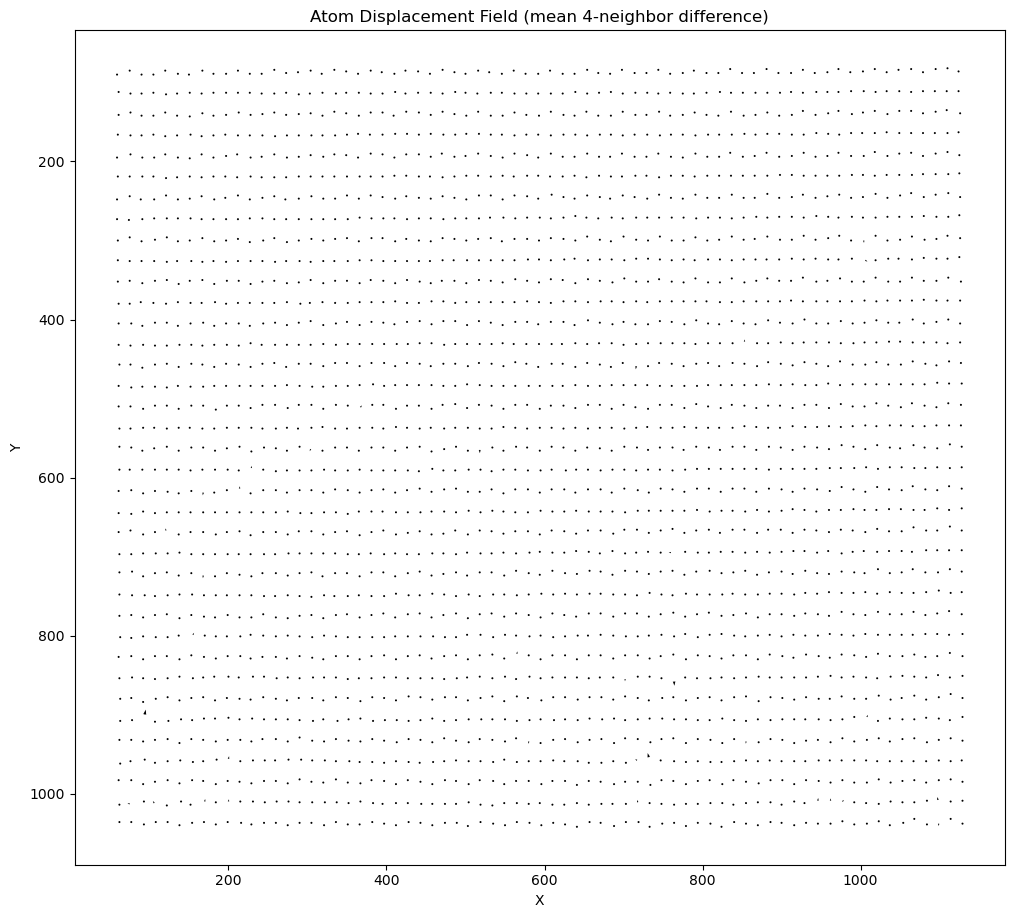

In [ ]:
xs = []
ys = []
us = []
vs = []

for (i, j), diff in diffs.items():
    patch = crop.grid[i, j]
    pos = np.array(patch.atom_position_roi)

    xs.append(pos[0])
    ys.append(pos[1])
    us.append(diff[0])
    vs.append(diff[1])

plt.figure(figsize=(12, 12))
plt.quiver(xs, ys, us, vs, angles='xy', scale_units='xy', scale=1)
# plt.scatter(xs, ys, s=10, color='black')  # optional: mark patch positions
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Atom Displacement Field (mean 4-neighbor difference)")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().invert_yaxis()
plt.show()

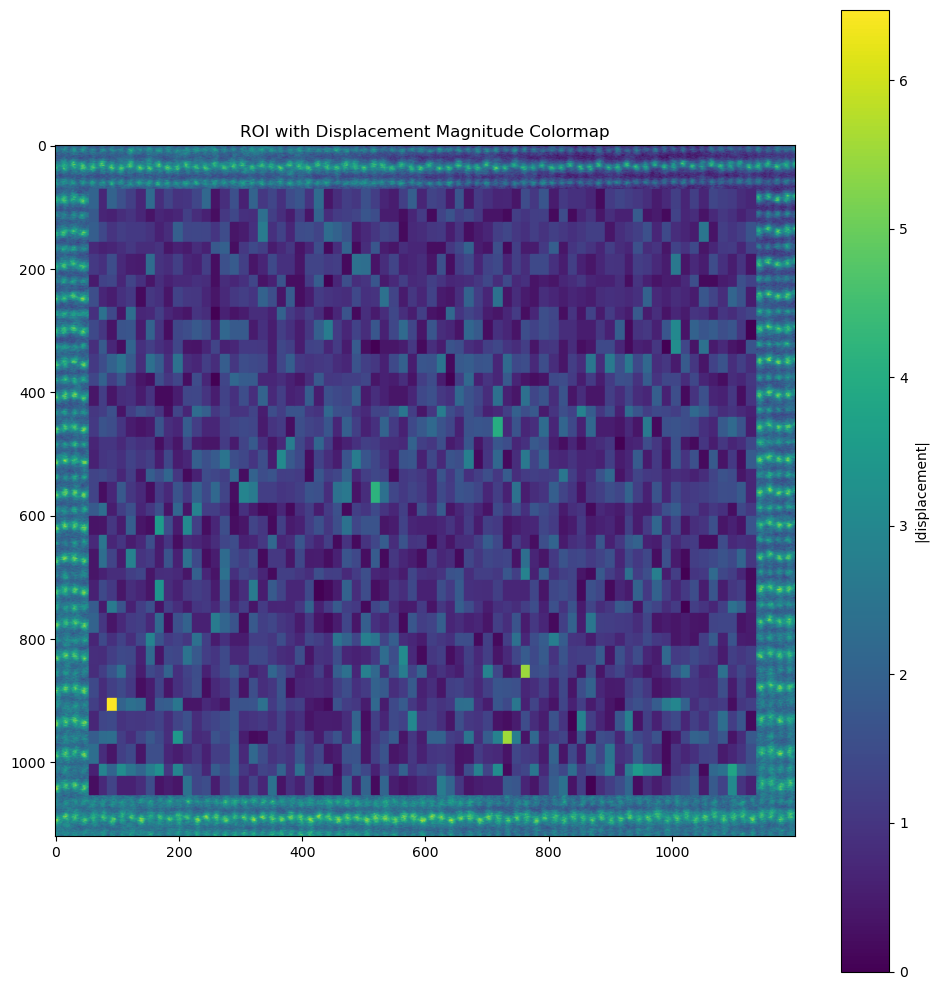

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib import cm, colors

# Compute displacement magnitudes
mags = [np.linalg.norm(diff) for diff in diffs.values()]
mags = np.array(mags)

# Normalize magnitudes for colormap
norm = colors.Normalize(vmin=np.min(mags), vmax=np.max(mags))

plt.close()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(crop.roi, cmap='viridis', zorder=0)
cmap=plt.get_cmap('viridis')

# Overlay boxes colored by displacement
for (i, j), diff in diffs.items():
    patch = crop.grid[i, j]
    mag = np.linalg.norm(diff)

    color = cmap(norm(mag))
    x0, x1 = patch.roi_col_edges
    y0, y1 = patch.roi_row_edges

    rect = Rectangle(
        (x0, y0),
        x1 - x0, y1 - y0,
        edgecolor=color,
        facecolor=color,
        fill=True,
        zorder=3
    )
    ax.add_patch(rect)

# Add colorbar legend
sm = cm.ScalarMappable(norm=norm, cmap='viridis')
sm.set_array([])  # required for colorbar
fig.colorbar(sm, ax=ax, label='|displacement|')

ax.set_title('ROI with Displacement Magnitude Colormap')
ax.set_aspect('equal')
ax.invert_yaxis()
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

